In [ ]:
#%%

##* IMPORT
import os, sys
import numpy as np
import mne

os.environ["QT_QPA_PLATFORM_PLUGIN_PATH"] = os.path.join(sys.prefix, "Library", "plugins", "platforms")

In [ ]:
#%%

##* DATA
# sample_data_folder = mne.datasets.sample.data_path() # 1.7 GB of Data, Downloaded.

# Data for this tutorial:
# sample_audvis_raw.fif (unfiltered)
# sample_audvis_filt-0-40_raw.fif (low pas filter 0 to 40)
SAMPLE_DATA_PATH = "./MNE/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif"
print("Data exists on drive: ", os.path.isfile(SAMPLE_DATA_PATH))

##* Raw data
raw = mne.io.read_raw_fif(SAMPLE_DATA_PATH)
# Projection: converts one set of points to another set (not repeatable on new set)
# Converting 3,2,5 -3D to 3,2 -2D. Can be used to reduce noise.

Data exists on drive:  True
Opening raw data file ./MNE/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


Using matplotlib as 2D backend.


d:\anaconda3\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


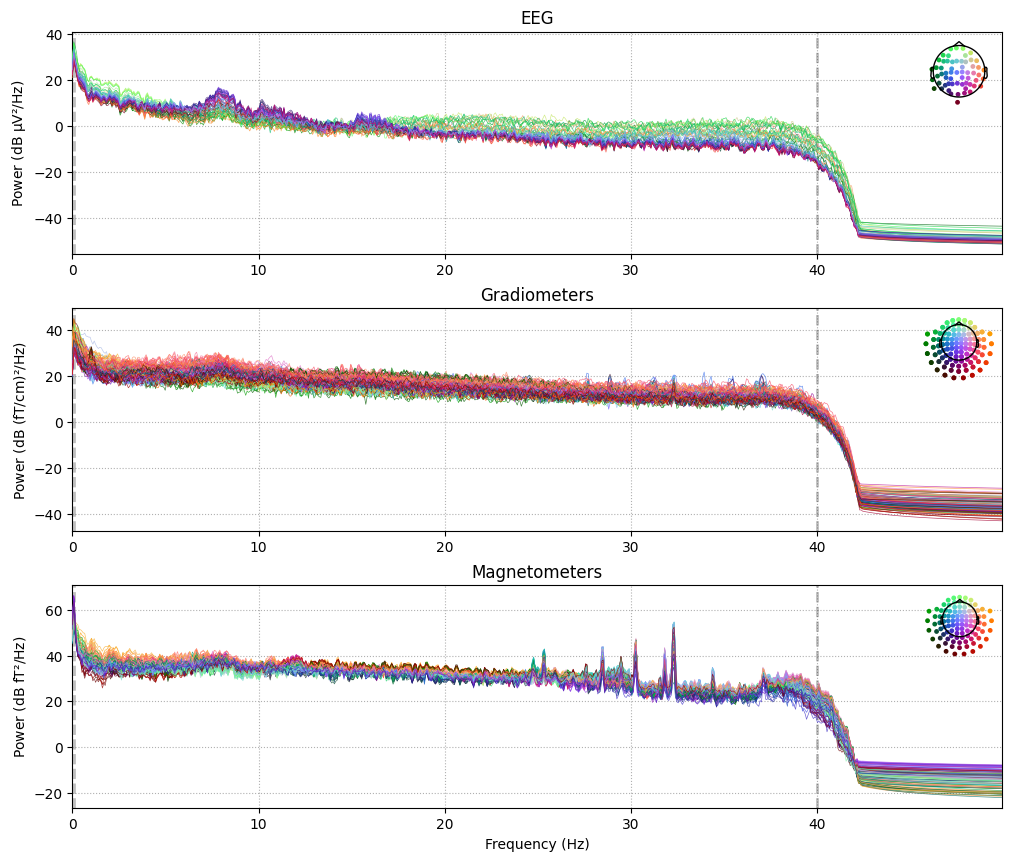

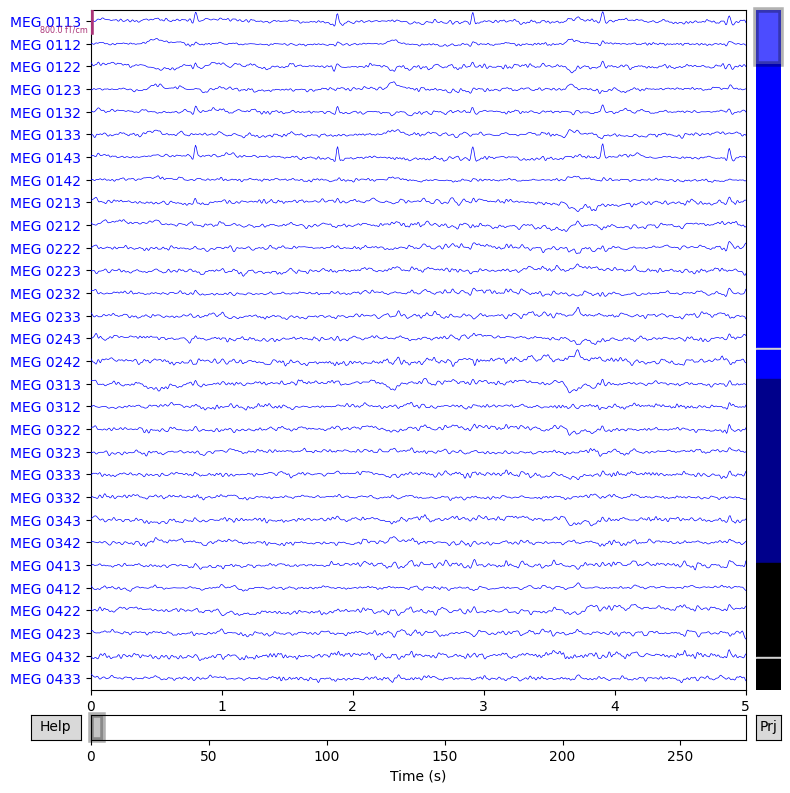

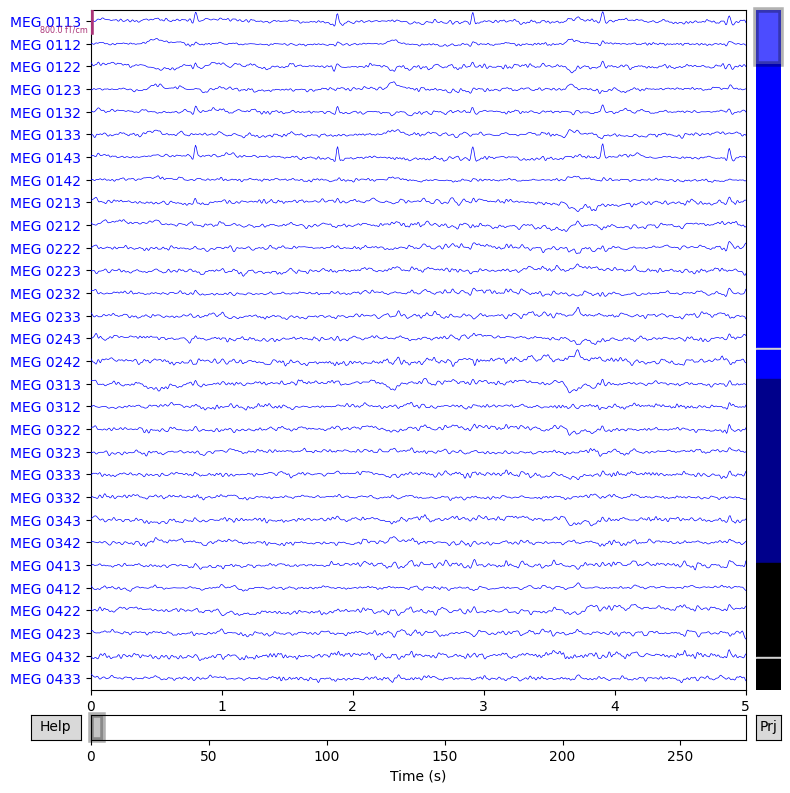

In [ ]:
#%%

##* Perform spectral analysis on sensor data. Plotting.
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw.plot(duration=5, n_channels=30)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.6s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


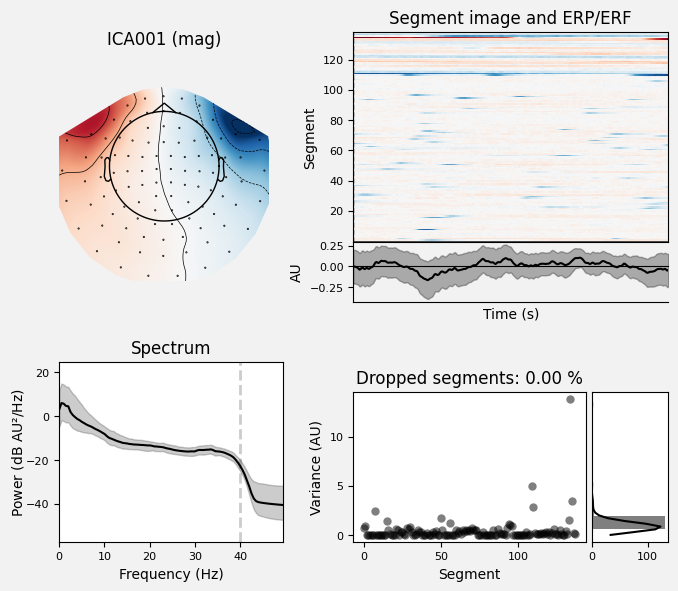

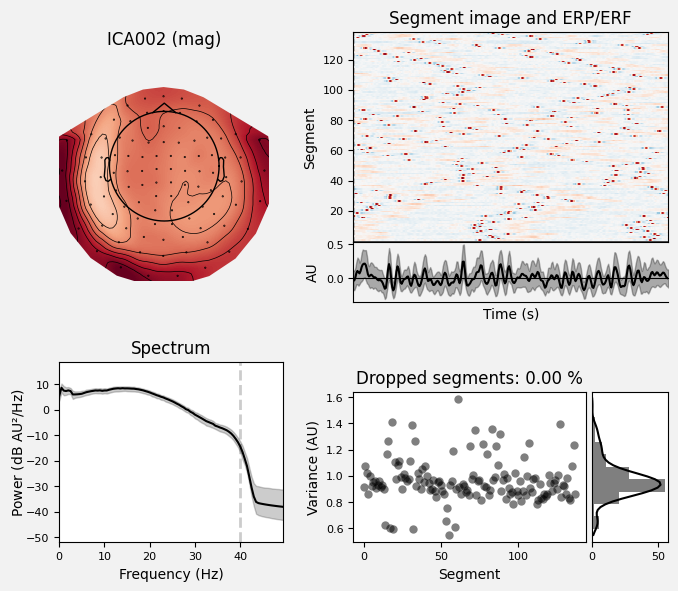

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [ ]:
# %%

##* Preprocessing
# Clean data via performing ICA (indep. components analysis)
# Automates the labeling of indep. components of neurophysiological data,
# and removal of artifacts.
# Here we exclude 1 and 2 which are for EOG and ECG.
# Visually monitor the data or find it automatically via dedicated channels.
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]
ica.plot_properties(raw, picks=ica.exclude)

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components


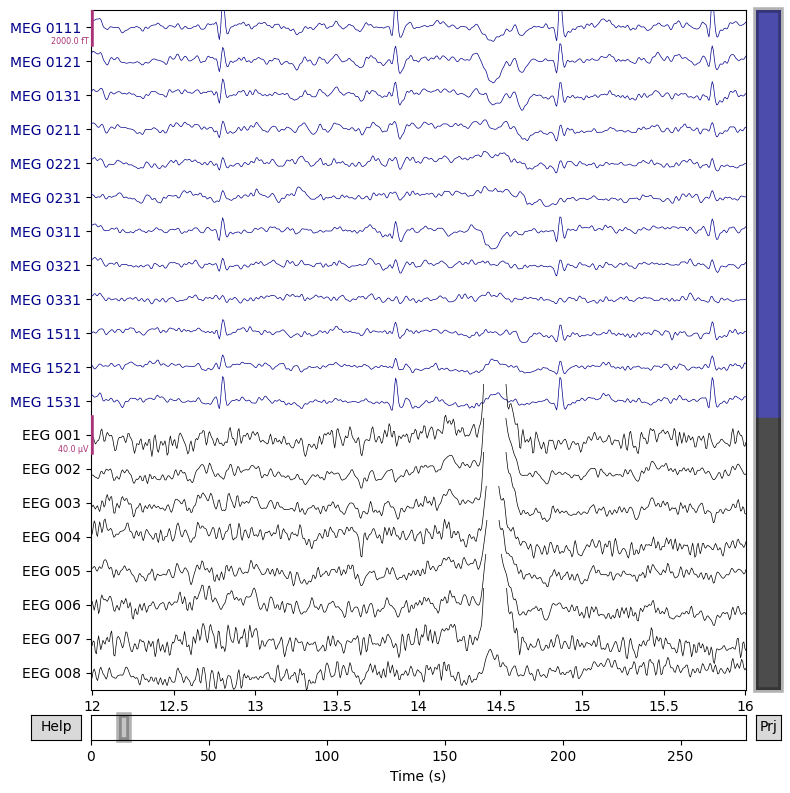

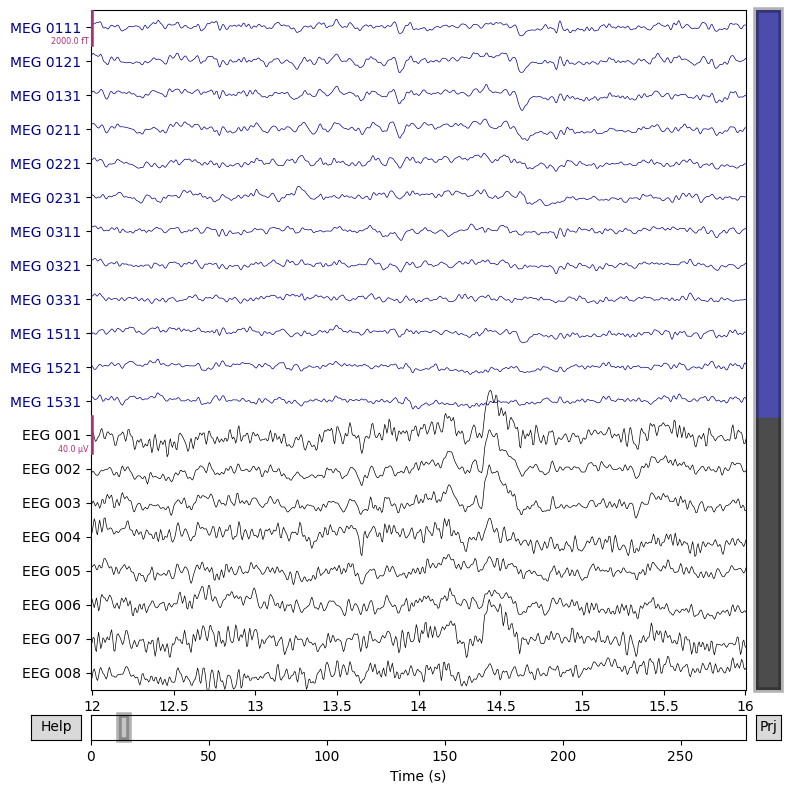

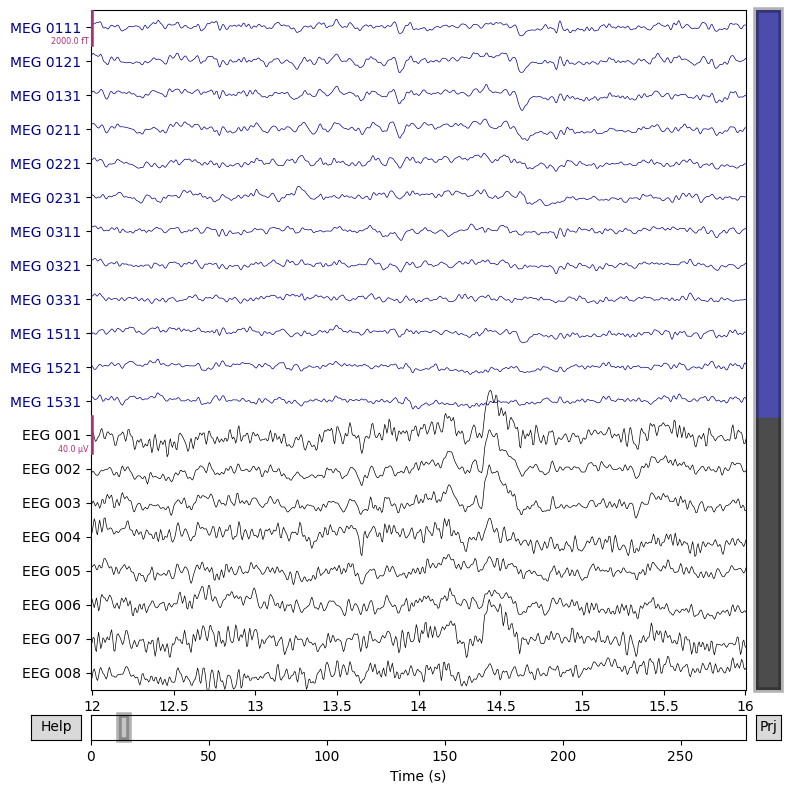

In [ ]:
#%%

# Apply the excluded parameters to ICA.
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)
# Show some frontal channels to clearly illustrate the artifact removal
chs = [
	"MEG 0111", "MEG 0121", "MEG 0131",
	"MEG 0211", "MEG 0221", "MEG 0231",
	"MEG 0311", "MEG 0321", "MEG 0331",
	"MEG 1511", "MEG 1521", "MEG 1531",
	"EEG 001",  "EEG 002",  "EEG 003",
	"EEG 004",  "EEG 005",  "EEG 006",
	"EEG 007",  "EEG 008",
]
chan_idx = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idx, start=12, duration=4)
raw.plot(order=chan_idx, start=12, duration=4)

319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


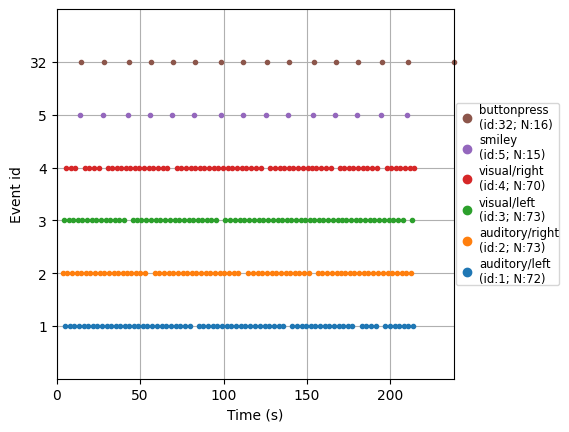

In [ ]:
#%%

##* Detecting experimental events (Event data)
# STIM Channels encode signals during recordings.
# A single channel (summation ch) combines all the STIMs.
# Here summation channel is "STI 014".
events = mne.find_events(raw, stim_channel="STI 014")
print(events[:5])

# Dict mappint for event ids (better readability)
event_dict = {
	"auditory/left": 1,
	"auditory/right": 2,
	"visual/left": 3,
	"visual/right": 4,
	"smiley": 5,
	"buttonpress": 32,
}
# Visualize the distribution of events across the recording.
# sfreq is sample-frequency; if not specified the x-axis will be baseed on sample
fig = mne.viz.plot_events(
	events, event_id=event_dict, sfreq=raw.info["sfreq"], first_samp=raw.first_samp
)

In [ ]:
#%%

##* Epoching continuous data (Continuous data)
# Epoch object min req: raw + event array
# Rejection dict (tuned for this dataset)
reject_criteria = dict(
	mag = 4000e-15, # 4000 femtoTesla
	grad = 4000e-13, # 4000 fT/cm
	eeg = 150e-6, # 150 miV
	eog = 250e-6 # 250 miV
)

epochs = mne.Epochs(
	raw, events, event_id=event_dict,
	tmin=-0.2, tmax=0.5, reject=reject_criteria,
	preload=True,
)

Not setting metadata
319 matching events found
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped


Dropped 7 epochs: 121, 195, 258, 271, 273, 274, 275
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


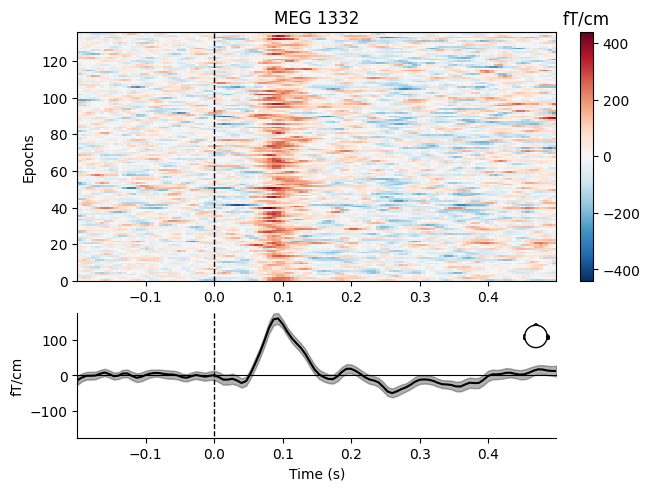

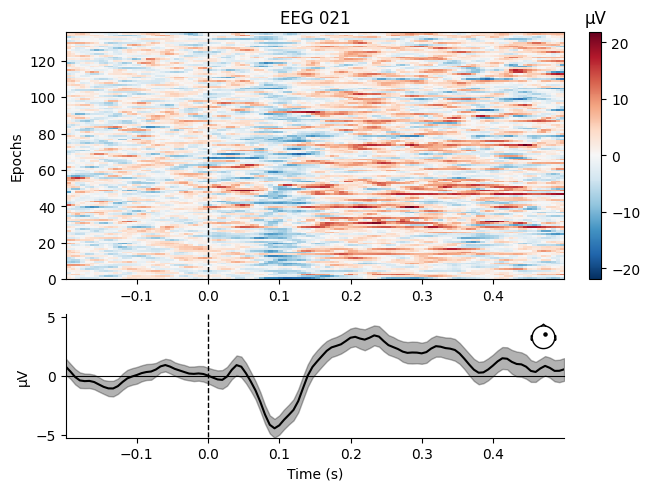

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [ ]:
# %%

##* Compare audio vs visual
# Pool from L and R channels to avoid biases.
conds_we_care = ["auditory/left", "auditory/right", "visual/left", "visual/right"]
epochs.equalize_event_counts(conds_we_care) # sample randomly
aud_epochs = epochs["auditory"]
vis_epochs = epochs["visual"]
del raw, epochs # free up memory

aud_epochs.plot_image(picks=["MEG 1332", "EEG 021"])

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    4.4s


No baseline correction applied


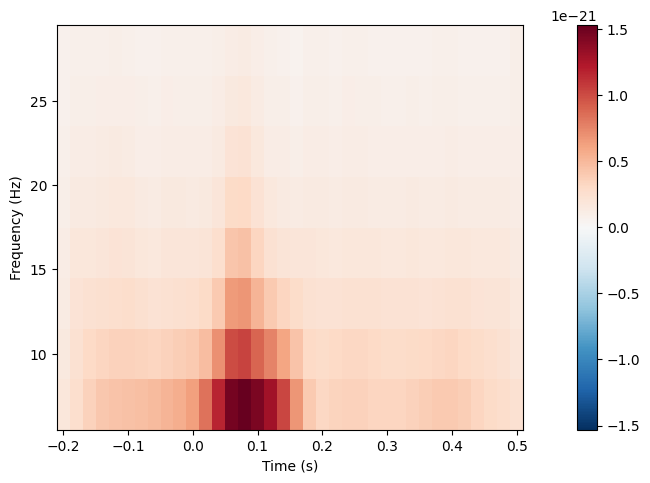

[<Figure size 640x480 with 2 Axes>]

In [ ]:
#%%

##* Time-Frequency Analysis
# To analyze the brian frequency changes in time
# Can compute time-freq representation (changes of ALPHA power),
# power spectral density (pre and post stimulus BETA power),
# and cross-spectral density (connectivity between regions).
freq = np.arange(7, 30, 3) # 7-30 Hz
power = aud_epochs.compute_tfr(
	"morlet", n_cycles=2, return_itc=False, freqs=freq, decim=3,
	average=True,
)
# return_itc is useful in phase-locking to stimuli
power.plot(["MEG 1332"])

Multiple channel types selected, returning one figure per type.
combining channels using RMS (grad channels)
combining channels using RMS (grad channels)


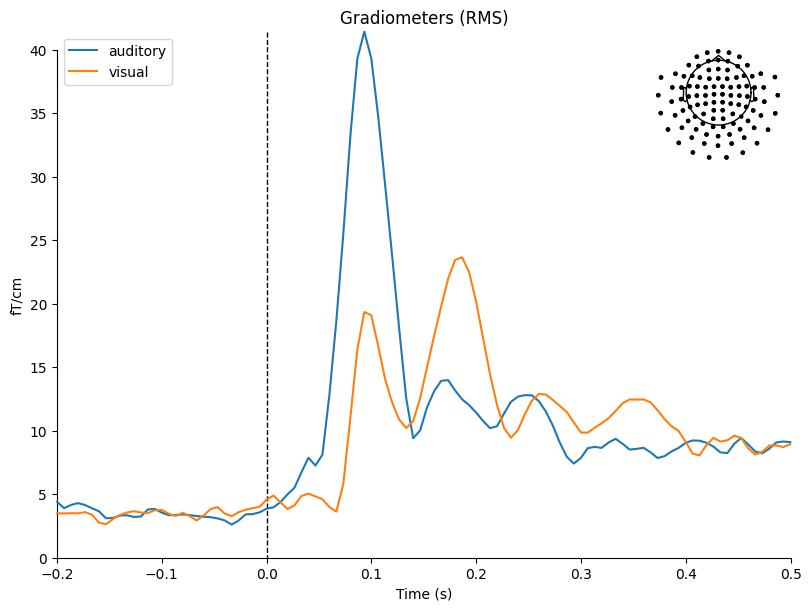

combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


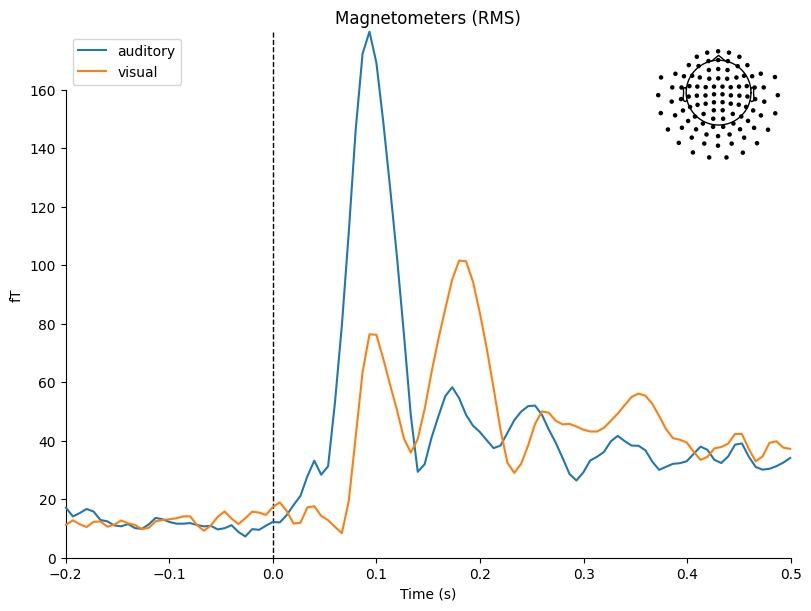

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


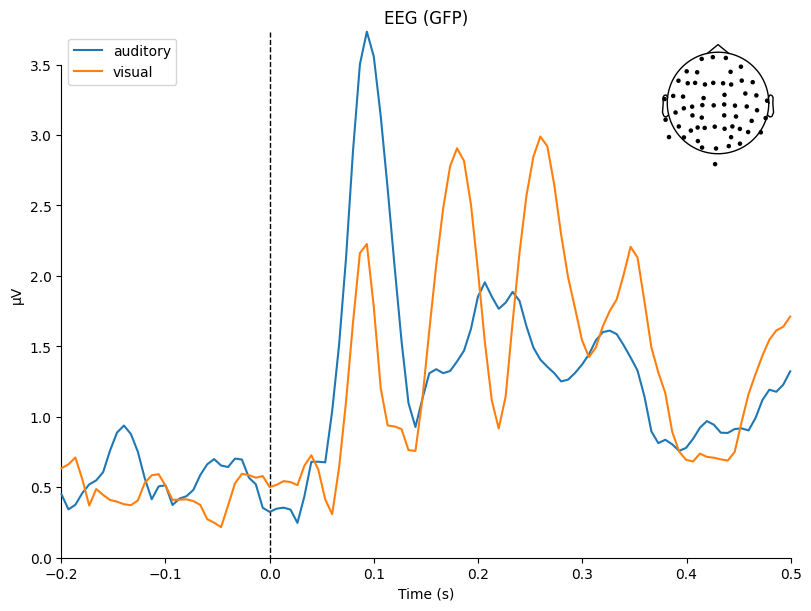

Projections have already been applied. Setting proj attribute to True.


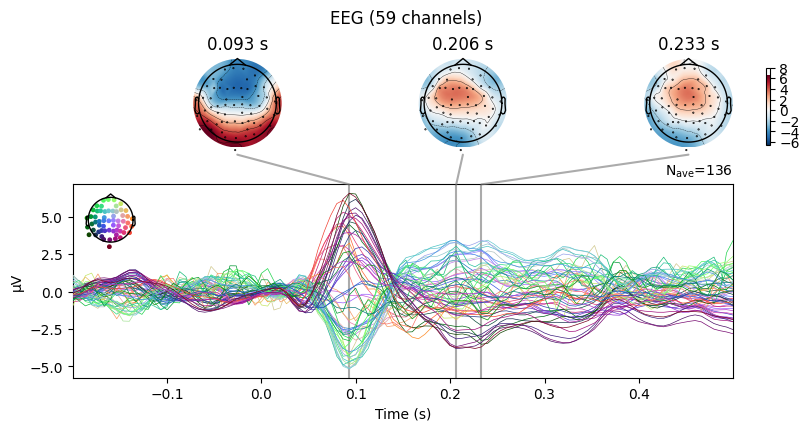

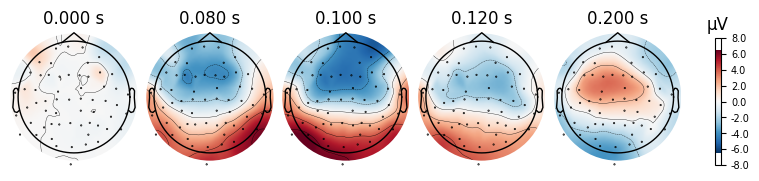

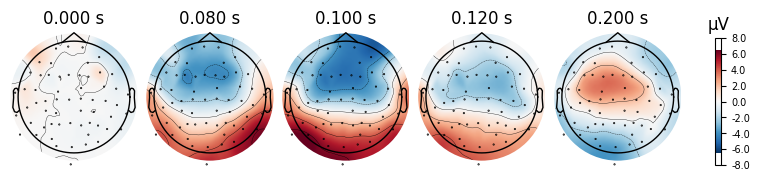

In [ ]:
#%%

##* Estimating evoked responses
# Average the epochs in each condition.
# Using plot_joint & _topomap we can plot more
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(
	dict(auditory=aud_evoked, visual=vis_evoked),
	legend="upper left",
	show_sensors="upper right",
)
aud_evoked.plot_joint(picks="eeg")
aud_evoked.plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="eeg")

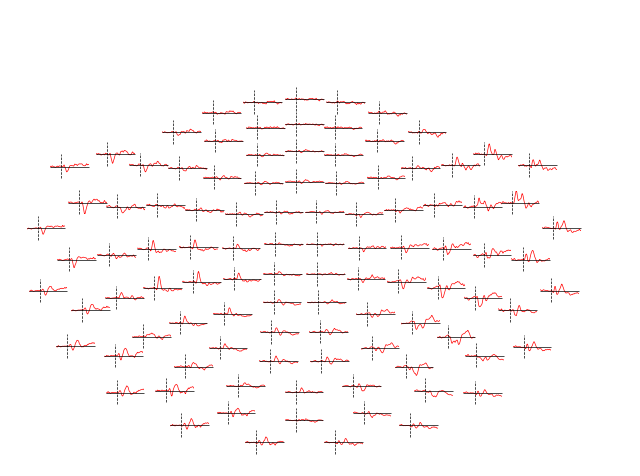

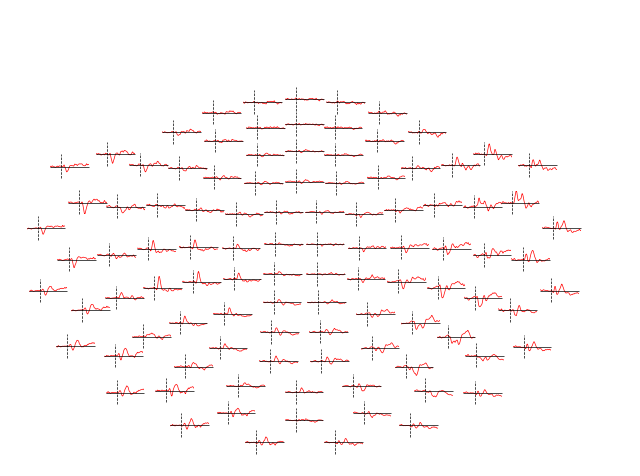

In [ ]:
#%%

# Combine evoked objects to show contrast
evoked_diff = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])
evoked_diff.pick(picks="mag").plot_topo(color="r", legend=False)

In [ ]:
#%%

##* Inverse modeling
# Find origin of evoked activity by projecting the data into source space.
# Here we use min-norm estimation (MNE) to generate a continuous map of activation
INVERSE_OPERATOR_DATA_PATH = "./MNE/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif"
print("Data exists on drive: ", os.path.isfile(INVERSE_OPERATOR_DATA_PATH))

inv_op = mne.minimum_norm.read_inverse_operator(INVERSE_OPERATOR_DATA_PATH)
# Signal-to-noise ratio to compute regularization parameter (lambda**2),
# meaning signal is 3x stronger than background noise.
snr = 3.0
# Lambda2 is based on the Bayesian estimation to fit and stabilize data.
lambda2 = 1.0 / snr**2
# Source Time Course generation
# Other methods are: dSPM, sLORETA, eLORETA
stc = mne.minimum_norm.apply_inverse(
	vis_evoked, inv_op, lambda2=lambda2, method="MNE"
)
# Plot the STC
# path to MRI
SUBJECT_MRI_DATA_PATH = "./MNE/mne_data/MNE-sample-data/subjects"
mne.viz.set_3d_backend('pyvistaqt')
stc.plot(
	initial_time=0.1, hemi="split", views=["lat", "med"],
	subjects_dir=SUBJECT_MRI_DATA_PATH
)

Data exists on drive:  True
Reading inverse operator decomposition from d:\Game Production\CS Degree\Python\MNE\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
  